<a href="https://colab.research.google.com/github/KamonohashiPerry/kaggle/blob/master/DataScienceBowl_2019_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename =  "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install kaggle

In [4]:
!kaggle competitions list

ref                                            deadline             category             reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started   Knowledge       2281           False  
titanic                                        2030-01-01 00:00:00  Getting Started   Knowledge      16115            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started   Knowledge       5344            True  
connectx                                       2030-01-01 00:00:00  Getting Started   Knowledge        234           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research          Knowledge         62           False  
competitive-data-science-predict-future-sales  2020-12-31 23:59:00  Playground            Kudos       5432            True  


In [5]:
!kaggle competitions download -c data-science-bowl-2019

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
specs.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from IPython.display import HTML
import warnings

pd.set_option('max_columns', 100)
pd.set_option('max_colwidth', 200)
pd.set_option('max_rows', 100)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
my_pal = sns.color_palette(n_colors=10)

In [7]:
ls -GFlash

total 439M
8.0K drwxr-xr-x 1 root 4.0K Jan 13 03:13 ./
4.0K drwxr-xr-x 1 root 4.0K Jan 13 03:03 ../
4.0K -rw-r--r-- 1 root 2.6K Jan 13 03:13 adc.json
8.0K drwxr-xr-x 1 root 4.0K Jan 13 03:13 .config/
4.0K drwxr-xr-x 1 root 4.0K Dec 18 16:52 sample_data/
 12K -rw-r--r-- 1 root  11K Jan 13 03:13 sample_submission.csv
400K -rw-r--r-- 1 root 400K Jan 13 03:13 specs.csv
 41M -rw-r--r-- 1 root  41M Jan 13 03:13 test.csv.zip
397M -rw-r--r-- 1 root 397M Jan 13 03:13 train.csv.zip
264K -rw-r--r-- 1 root 262K Jan 13 03:13 train_labels.csv.zip


In [0]:
# read in the data csv files
train = pd.read_csv('train.csv.zip')

In [0]:
train.shape

(11341042, 11)

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341042 entries, 0 to 11341041
Data columns (total 11 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
dtypes: int64(3), object(8)
memory usage: 951.8+ MB


うむ、1GB近くあるのですね。

In [0]:
train_labels = pd.read_csv('train_labels.csv.zip')

In [0]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 7 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
num_correct        17690 non-null int64
num_incorrect      17690 non-null int64
accuracy           17690 non-null float64
accuracy_group     17690 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 967.5+ KB


In [0]:
test = pd.read_csv('test.csv.zip')
specs = pd.read_csv('specs.csv')
ss = pd.read_csv('sample_submission.csv')

In [0]:
train_smp = train.sample(1000000, random_state=123)

In [0]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


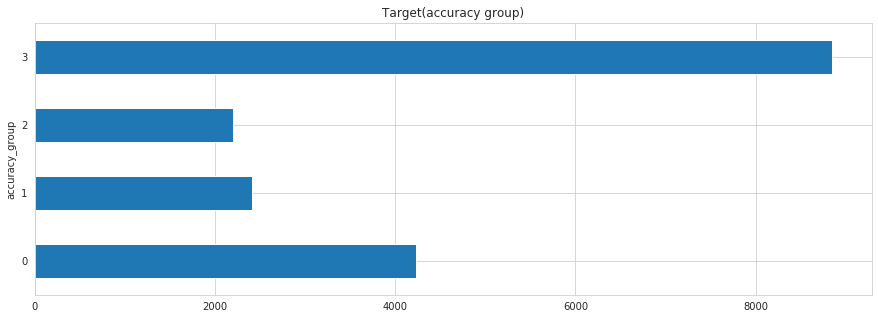

In [0]:
train_labels.groupby('accuracy_group')['game_session'].count().plot(kind='barh', figsize=(15, 5), title='Target(accuracy group)')
plt.show()

0過剰ポアソン分布みたいな形になっている？  
グループはカテゴリカル変数で与えられているが、もとのデータは整数値を取るはずで、それが何らかの分布に従っているのではないかと思われる。

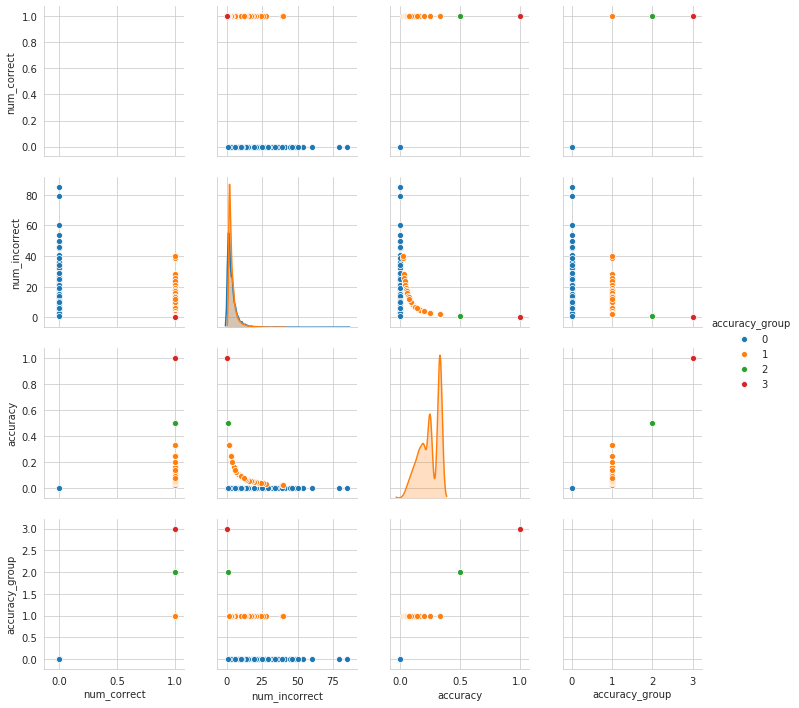

In [0]:
sns.pairplot(train_labels, hue='accuracy_group')
plt.show()

In [0]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0,""event_code"":2000}",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"",""identifier"":""Dot_LetsSandcastle,Dot_FillMold,Dot_Mol...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"",""identifier"":""Dot_LetsSandcastle,Dot_FillMold,Dot_Mol...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [11]:
%%time
# event_id & game_session
train['event_id_as_int'] = train['event_id'].apply(lambda x: int(x, 16))
train['game_session_as_int'] = train['game_session'].apply(lambda x: int(x, 16))

CPU times: user 11.5 s, sys: 420 ms, total: 11.9 s
Wall time: 11.9 s


In [0]:
train['event_id_as_int'].value_counts()

321209981     274673
3141416715    256179
3481448278    224694
1585523495    206129
3485288392    199734
               ...  
1081391810         1
1572895192         1
295394050          1
399128921          1
2831970284         1
Name: event_id_as_int, Length: 384, dtype: int64

In [0]:
train['game_session_as_int'].value_counts()

7957413586569608673     3368
13483506718690993760    3182
3695586738793492217     2505
3803337315533600652     2456
10367474617437948420    2398
                        ... 
6956492396539761871        1
13636289567656964288       1
7157752131875516434        1
12061113909191278358       1
7863511568735651636        1
Name: game_session_as_int, Length: 303319, dtype: int64

In [12]:
%%time
# timestamp

# format
train['timestamp'] = pd.to_datetime(train['timestamp'])
# make date
train['date'] = train['timestamp'].dt.date
# make hour
train['hour'] = train['timestamp'].dt.hour
# make weekday name
train['weekday_name'] = train['timestamp'].dt.weekday_name

# same for test
test['timestamp'] = pd.to_datetime(test['timestamp'])
test['date'] = test['timestamp'].dt.date
test['hour'] = test['timestamp'].dt.hour
test['weekday_name'] = test['timestamp'].dt.weekday_name

CPU times: user 14.7 s, sys: 808 ms, total: 15.5 s
Wall time: 15.5 s


In [0]:
print(f'Train data has shape: {train.shape}')
print(f'Test data has shape: {test.shape}')

Train data has shape: (11341042, 16)
Test data has shape: (1156414, 14)


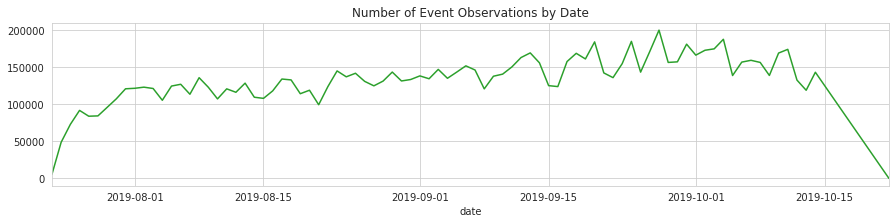

In [0]:
train.groupby('date')['event_id'].agg('count').plot(figsize=(15, 3),
                                                    title='Number of Event Observations by Date',
                                                    color=my_pal[2])
plt.show()

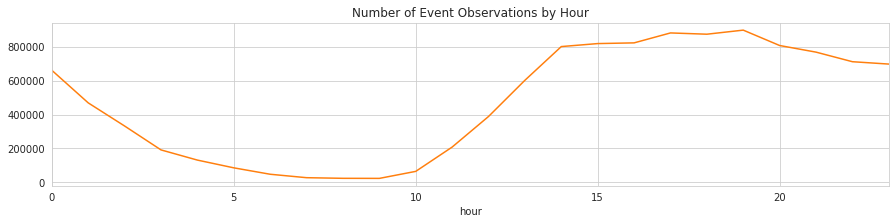

In [0]:
train.groupby('hour')['event_id'].agg('count').plot(figsize=(15, 3),
                                                    title='Number of Event Observations by Hour',
                                                    color=my_pal[1])
plt.show()

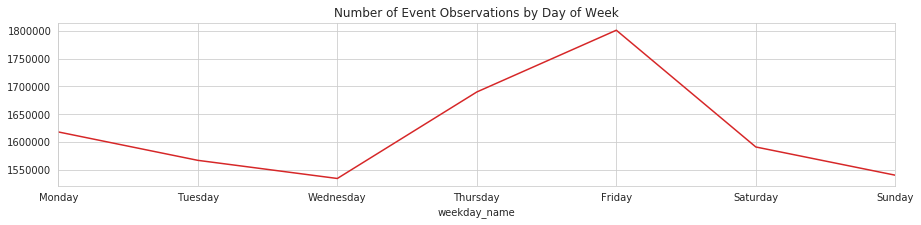

In [0]:
train.groupby('weekday_name')['event_id'].agg('count').T[['Monday', 'Tuesday', 'Wednesday',
                                                          'Thursday', 'Friday', 'Saturday', 'Sunday']].T.plot(figsize=(15, 3),
                                                                                                              title='Number of Event Observations by Day of Week',
                                                                                                              color=my_pal[3])
plt.show()

In [0]:
cross_df = train.groupby(['hour', 'weekday_name'])['event_id'].agg('count').reset_index()
cross_df = cross_df.pivot( 'hour','weekday_name', 'event_id')

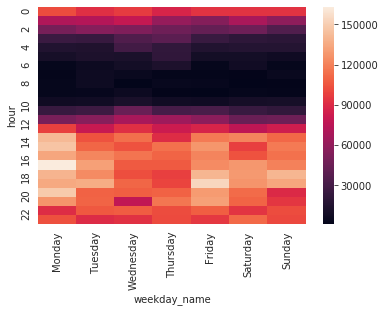

In [0]:
sns.heatmap(cross_df, xticklabels=['Monday', 'Tuesday', 'Wednesday',
                                    'Thursday', 'Friday', 'Saturday', 'Sunday']);

+ 月曜日の夕方が多い。
+ 金曜日の夕方が多い。
+ 午前中にプレイすることはあまりなさそう。

あれ、祝日とかわからないのだろうか。  
国がわからない。

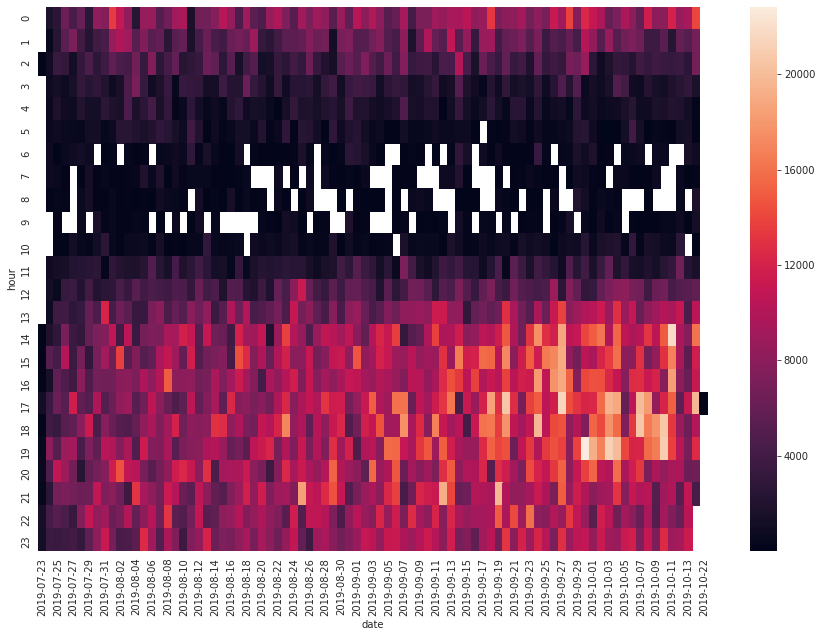

In [0]:
cross_df = train.groupby(['hour', 'date'])['event_id'].agg('count').reset_index()
cross_df = cross_df.pivot( 'hour','date', 'event_id')
fig, ax = plt.subplots(figsize=(15,10)) 
ax = sns.heatmap(cross_df);

欠損している時間帯があるということ？

In [0]:
# event data
print(train['event_data'][4])
print(train['event_data'][5])

{"description":"Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!","identifier":"Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape","media_type":"audio","duration":6919,"event_count":3,"game_time":6972,"event_code":3110}
{"coordinates":{"x":583,"y":605,"stage_width":1015,"stage_height":762},"event_count":4,"game_time":9991,"event_code":4070}


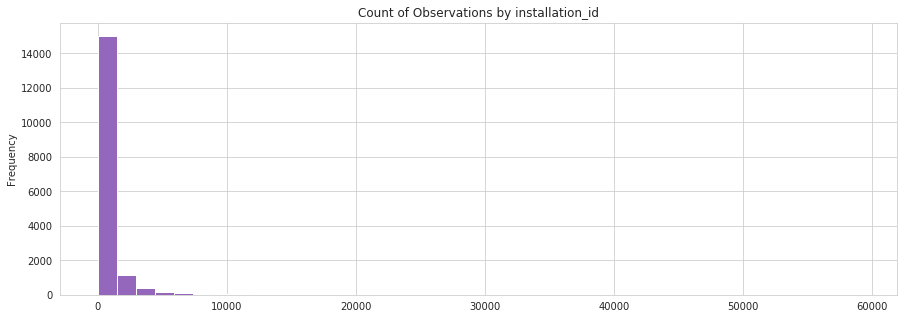

In [0]:
train.groupby('installation_id').count()['event_id'].plot(kind='hist',
                                                          bins=40,
                                                          color=my_pal[4],
                                                          figsize=(15, 5),
                                                          title='Count of Observations by installation_id')
plt.show()

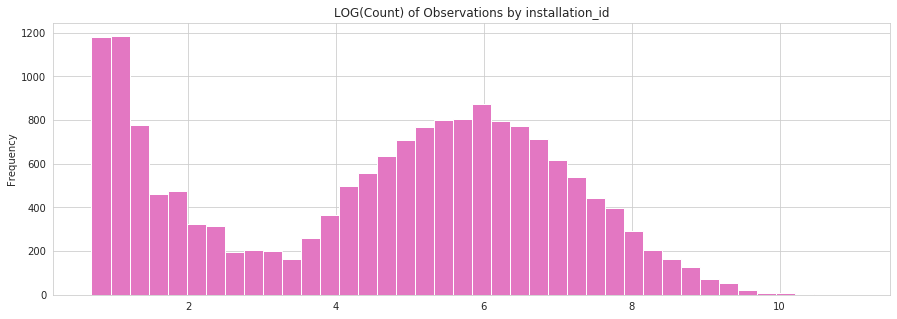

In [0]:
train.groupby('installation_id').count()['event_id'].apply(np.log1p).plot(kind='hist',
                                                                          bins=40,
                                                                          color=my_pal[6],
                                                                          figsize=(15, 5),
                                                                          title='LOG(Count) of Observations by installation_id')
plt.show();

ゼロ過剰ポアソン分布みたいな形になっている。

In [0]:
train.groupby('installation_id').count()['event_id'].sort_values(ascending=False).head(5)

installation_id
f1c21eda    58988
4d7d3d97    32749
d25338cb    31826
cff5a334    30918
c9ea32e9    30402
Name: event_id, dtype: int64

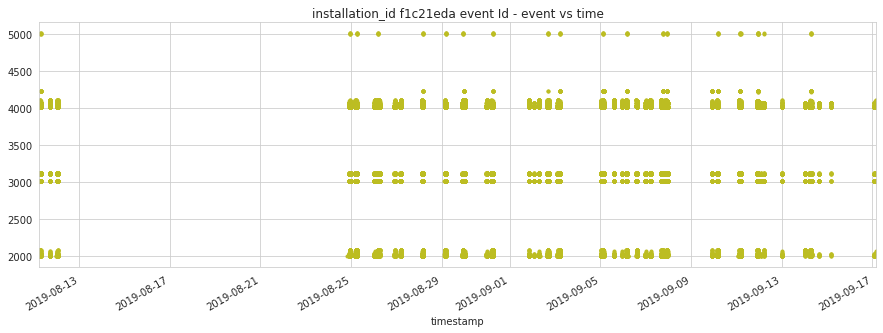

In [0]:
# botぽいインスタンスに注目する
train.query('installation_id == "f1c21eda" ').set_index('timestamp')['event_code'].plot(figsize=(15, 5),
                                                                                        title='installation_id f1c21eda event Id - event vs time',
                                                                                        style='.',
                                                                                        color=my_pal[8])
plt.show()

Botぽいユーザーを除外する処理を書く必要があるかも。 
+ 頻度が高すぎる
+ おかしな時間にアクセス
+ アクセス間隔が一定

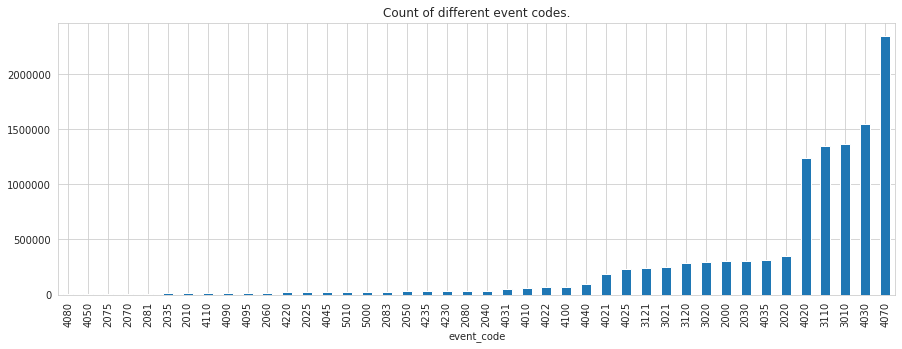

In [0]:
# event_code
train.groupby('event_code').count()['event_id'].sort_values().plot(kind='bar',
                                                                   figsize=(15, 5),
                                                                   title='Count of different event codes.')
plt.show()

In [0]:
train[train['event_code'] == 4070].event_data

5                      {"coordinates":{"x":583,"y":605,"stage_width":1015,"stage_height":762},"event_count":4,"game_time":9991,"event_code":4070}
6                     {"coordinates":{"x":601,"y":570,"stage_width":1015,"stage_height":762},"event_count":5,"game_time":10622,"event_code":4070}
7                     {"coordinates":{"x":250,"y":665,"stage_width":1015,"stage_height":762},"event_count":6,"game_time":11255,"event_code":4070}
8                     {"coordinates":{"x":279,"y":629,"stage_width":1015,"stage_height":762},"event_count":7,"game_time":11689,"event_code":4070}
9                     {"coordinates":{"x":839,"y":654,"stage_width":1015,"stage_height":762},"event_count":8,"game_time":12272,"event_code":4070}
                                                                            ...                                                                  
11341028    {"coordinates":{"x":74,"y":359,"stage_width":1014,"stage_height":468},"round":0,"event_count":57,"game_time":395

In [0]:
train[train['event_code'] == 4030].event_data

56            {"size":0,"coordinates":{"x":782,"y":207,"stage_width":1015,"stage_height":762},"event_count":55,"game_time":34324,"event_code":4030}
59            {"size":0,"coordinates":{"x":782,"y":207,"stage_width":1015,"stage_height":762},"event_count":58,"game_time":35857,"event_code":4030}
65            {"size":0,"coordinates":{"x":782,"y":207,"stage_width":1015,"stage_height":762},"event_count":64,"game_time":36808,"event_code":4030}
70            {"size":0,"coordinates":{"x":782,"y":207,"stage_width":1015,"stage_height":762},"event_count":69,"game_time":37607,"event_code":4030}
72            {"size":0,"coordinates":{"x":782,"y":207,"stage_width":1015,"stage_height":762},"event_count":71,"game_time":37824,"event_code":4030}
                                                                             ...                                                                   
11340940     {"rocket":5,"coordinates":{"x":525,"y":612,"stage_width":1015,"stage_height":762},"event_count":13,

event_codeの前処理をする必要がある。  

In [0]:
type(train['event_data'][0])

str

In [13]:
# 文字列をjsonにして解析していく
import json
di = json.loads(train['event_data'][10])
di

{'coordinates': {'stage_height': 762, 'stage_width': 1015, 'x': 807, 'y': 619},
 'event_code': 4070,
 'event_count': 9,
 'game_time': 12672}

In [0]:
# train.describe(include='all')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour,weekday_name
count,11341042,11341042,11341042,11341042,11341042,1.134104e+07,1.134104e+07,1.134104e+07,11341042,11341042,11341042,1.134104e+07,1.134104e+07,11341042,1.134104e+07,11341042
unique,384,303319,10777308,10893749,17000,NaN,NaN,NaN,44,4,4,NaN,NaN,85,NaN,7
top,1325467d,6e6e697f2e593de1,2019-08-01 20:08:13.052000+00:00,"{""event_code"": 2000, ""event_count"": 1}",f1c21eda,NaN,NaN,NaN,Chow Time,Game,MAGMAPEAK,NaN,NaN,2019-09-27,NaN,Friday
freq,274673,3368,11,183676,58988,NaN,NaN,NaN,1150974,5795293,5023687,NaN,NaN,200217,NaN,1801243
first,NaN,NaN,2019-07-23 02:12:17.279000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2019-10-22 17:41:45.983000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.056642e+02,3.513838e+03,1.976236e+05,NaN,NaN,NaN,2.040969e+09,9.251977e+18,NaN,1.477273e+01,NaN
std,NaN,NaN,NaN,NaN,NaN,1.483477e+02,6.816470e+02,1.803968e+06,NaN,NaN,NaN,1.197760e+09,5.332447e+18,NaN,6.779303e+00,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000e+00,2.000000e+03,0.000000e+00,NaN,NaN,NaN,3.986158e+06,1.351784e+13,NaN,0.000000e+00,NaN
25%,NaN,NaN,NaN,NaN,NaN,2.500000e+01,3.021000e+03,3.061800e+04,NaN,NaN,NaN,1.032610e+09,4.607136e+18,NaN,1.300000e+01,NaN


In [0]:
import tqdm

In [0]:
event_code_df = train[~train.event_code.duplicated(keep="first")].reset_index(drop=True)

In [16]:
data_frame = pd.DataFrame(columns=["path_name", "value", "ids"])

for iteration in tqdm.tqdm(range(event_code_df.index.size)):
  json_dict = json.loads(event_code_df['event_data'][iteration])
  ids = train.index[iteration]

  # JSONのパース
  for k,v in json_dict.items(): 
      if isinstance(v, dict):
          for x,y in v.items():
              if isinstance(y, dict):
                  for xx,yy in y.items():
                      if isinstance(yy, list):
                          for each_element in yy:
                              ids = ids + 1
                              if isinstance(each_element, dict):
                                  for xxx,yyy in each_element.items():
                                      path_string = str(k)+"."+str(x)+"."+str(xx)+"."+str(xxx)
                                      df = pd.DataFrame([[str(path_string), str(yyy), ids]],
                                                                            columns=data_frame.columns)
                                      data_frame = data_frame.append(df).reset_index(drop=True)
                      else:
                          if isinstance(yy, dict):
                              for each_element_x,each_element_y  in yy.items():
                                  if isinstance(each_element_y, dict):
                                      for xxx,yyy in each_element_y.items():
                                          path_string = str(k)+"."+str(x)+"."+str(xx)+"."+ str(each_element_x) + "." +str(xxx)
                                          df = pd.DataFrame([[str(path_string), str(yyy), ids]],
                                                                            columns=data_frame.columns)
                                          data_frame = data_frame.append(df).reset_index(drop=True)


                                  elif isinstance(each_element_y, str):
                                      path_string = str(k)+"."+str(x)+"."+str(xx)+ "."+ str(each_element_x) 
                                      df = pd.DataFrame([[str(path_string), str(each_element_y), ids]],
                                                                              columns=data_frame.columns)
                                      data_frame = data_frame.append(df).reset_index(drop=True)

                          else:
                              path_string = str(k)+"."+str(x)+"."+str(xx)
                              df = pd.DataFrame([[str(path_string), str(yy), ids]],
                                              columns=data_frame.columns)
                              data_frame = data_frame.append(df).reset_index(drop=True)


              else:
                  path_string = str(k)+"."+str(x)
                  df = pd.DataFrame([[str(path_string), str(y), ids]],
                                    columns=data_frame.columns)
                  data_frame = data_frame.append(df).reset_index(drop=True)
      else:
        path_string = str(k)
        df = pd.DataFrame([[str(path_string), str(v), ids]],
                            columns=data_frame.columns)
        data_frame = data_frame.append(df).reset_index(drop=True)

100%|██████████| 42/42 [00:00<00:00, 90.22it/s]


In [17]:
data_frame.path_name.value_counts()/event_code_df.index.size

event_code                  1.000000
event_count                 1.000000
game_time                   0.976190
round                       0.595238
duration                    0.428571
coordinates.x               0.285714
level                       0.285714
coordinates.stage_width     0.285714
coordinates.y               0.285714
coordinates.stage_height    0.285714
description                 0.214286
identifier                  0.142857
media_type                  0.142857
size                        0.095238
movie_id                    0.071429
total_duration              0.071429
castles_placed              0.047619
misses                      0.047619
round_target.size           0.047619
stumps                      0.047619
toy                         0.047619
round_target.type           0.047619
round_target.animal         0.047619
filled                      0.047619
object                      0.047619
water_level                 0.047619
dinosaurs                   0.023810
f

+ game_timeはほとんどで入っている。
+ round
+ duration
+ coordinates.stage_height
+ coordinates.x
+ level
+ coordinates.stage_width
+ coordinates.y

trainに横持ちでこれらのデータを付けていきたい。

In [0]:
event_data_json_list = ['event_code','event_count','description','identifier','media_type',
 'total_duration','game_time','duration','coordinates','castles_placed',
 'molds','size','sand','filled','level','round','movie_id','round_target',
 'options','animals','misses','shell_size','cloud','cloud_size','water_level',
 'time_played','houses','dinosaurs','dinosaurs_placed','flower','flowers',
 'height','stumps','source','correct','session_duration','exit_type','distance',
 'target_containers','object','tutorial_step','toy','dwell_time','max_position',
 'end_position']
event_data_json_list_column_name = [ 'j_' + i for i in event_data_json_list]

In [0]:
# jsonの要素に関してカラムを作る
new_cols = event_data_json_list_column_name
new_vals = np.zeros((len(event_data_json_list_column_name))).tolist()
new_vals = np.nan

train = train.reindex(columns=train.columns.tolist() + new_cols)   # add empty cols
train[new_cols] = new_vals

In [0]:
# 辞書形式からキーとバリューを抽出する
def extract_from_dict(dictionary, key):
    if dictionary != None:
        return dictionary[key]
    else:
        return None

def extract_match_key_from_dict(text, key):
  import json
  dictionary = json.loads(text)
  try:
    return dictionary[key]
  except:
    return None

In [22]:
train.head(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour,weekday_name,j_event_code,j_event_count,j_description,j_identifier,j_media_type,j_total_duration,j_game_time,j_duration,j_coordinates,j_castles_placed,j_molds,j_size,j_sand,j_filled,j_level,j_round,j_movie_id,j_round_target,j_options,j_animals,j_misses,j_shell_size,j_cloud,j_cloud_size,j_water_level,j_time_played,j_houses,j_dinosaurs,j_dinosaurs_placed,j_flower,j_flowers,j_height,j_stumps,j_source,j_correct,j_session_duration,j_exit_type,j_distance,j_target_containers,j_object,j_tutorial_step,j_toy,j_dwell_time,j_max_position,j_end_position
0,27253bdc,45bb1e1b6b50c07b,2019-09-06 17:53:46.937000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,656751580,5024642912375324795,2019-09-06,17,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27253bdc,17eeb7f223665f53,2019-09-06 17:54:17.519000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,656751580,1724517957933358931,2019-09-06,17,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,77261ab5,0848ef14a8dc6892,2019-09-06 17:54:56.302000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0,""event_code"":2000}",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,1998985909,596989822637992082,2019-09-06,17,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b2dba42b,0848ef14a8dc6892,2019-09-06 17:54:56.387000+00:00,"{""description"":""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"",""identifier"":""Dot_LetsSandcastle,Dot_FillMold,Dot_Mol...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK,3000738859,596989822637992082,2019-09-06,17,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06 17:55:03.253000+00:00,"{""description"":""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"",""identifier"":""Dot_LetsSandcastle,Dot_FillMold,Dot_Mol...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK,464911323,596989822637992082,2019-09-06,17,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
di

{'coordinates': {'stage_height': 762, 'stage_width': 1015, 'x': 807, 'y': 619},
 'event_code': 4070,
 'event_count': 9,
 'game_time': 12672}

In [34]:
train.shape

(11341042, 66)

In [36]:
%%time
aaa = list(map(lambda text:extract_match_key_from_dict(text, 'molds'), train['event_data']))

CPU times: user 55.8 s, sys: 8.42 ms, total: 55.8 s
Wall time: 55.8 s


1カラム1分くらいでいける？

In [27]:
for i in tqdm.tqdm(range(len(event_data_json_list))):
 train[event_data_json_list_column_name[i]] = list(map(lambda text:extract_match_key_from_dict(text, event_data_json_list[i]), train['event_data']))

100%|██████████| 45/45 [48:55<00:00, 65.06s/it]


In [28]:
train.to_csv('train_json_preprocessed.csv', index=None)

MessageError: ignored

In [32]:
files.download("/content/train_json_preprocessed.csv")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 35930, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
from google.colab import files

In [36]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 135004 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.15-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.15-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.15-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [39]:
# drive mean root directory of  google drive
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive/"Colab Notebooks"/Kaggle

DataScienceBowl_2019_v1.ipynb  PSI_Tutorial.ipynb  Titanic_v2.ipynb
kaggle.json		       Titanic_v1.ipynb


In [0]:
train.to_pickle("drive/Colab Notebooks/Kaggle/train_json_preprocessed.pickle")